* Image size: (224, 224, 3)

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


# Load Dataset

In [2]:
train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/validation.csv')
test_df = pd.read_csv('./data/test.csv')

print('Train:\t\t', train_df.shape, '\t', len(train_df['label'].unique()))
print('Validation:\t', val_df.shape, '\t', len(val_df['label'].unique()))
print('Test:\t\t', test_df.shape)

Train:		 (194828, 3) 	 128
Validation:	 (6400, 3) 	 128
Test:		 (12800, 2)


In [3]:
train_df.head()

,id,label,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...


In [4]:
# Helper function
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

img_size = (224, 224, 3)

# VGG16

## Stage 1 - Initial training

In [5]:
# For reproduciable purpose
seed = 29
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=128, classes=classes, 
                                                target_size=img_size[:2])

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=img_size[:2])

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


In [6]:
# Load pre-trained VGG16
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=img_size)

# Define new CNN models
vgg16 = Sequential()
vgg16.add(vgg16_base)
vgg16.add(Flatten(name='flatten'))
vgg16.add(Dropout(rate=0.5, name='dropout'))
vgg16.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
vgg16_base.trainable = False

# Model summary
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               3211392   
Total params: 17,926,080
Trainable params: 3,211,392
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Compile the model
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 40:
        lr *= 3e-1
    elif epoch > 30:
        lr *= 5e-1
    elif epoch > 20:
        lr *= 7e-1
    elif epoch > 10:
        lr *= 9e-1
    print('Learning rate: ', lr)
    return lr

opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16-1-layer-dropout-stage-1-ckpt.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg16.fit_generator(train_generator, steps_per_epoch=100, epochs=50, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)

vgg16.save('./models/vgg16-1-layer-dropout-stage-1-model.h5')
_ = gc.collect()

Learning rate:  0.001
Epoch 1/50
Learning rate:  0.001
 - 211s - loss: 2.9412 - acc: 0.3506 - val_loss: 2.3971 - val_acc: 0.4547
Epoch 2/50
Learning rate:  0.001
 - 188s - loss: 2.1352 - acc: 0.4991 - val_loss: 2.0856 - val_acc: 0.5092
Epoch 3/50
Learning rate:  0.001
 - 188s - loss: 1.9958 - acc: 0.5330 - val_loss: 2.0490 - val_acc: 0.5334
Epoch 4/50
Learning rate:  0.001
 - 193s - loss: 1.9390 - acc: 0.5610 - val_loss: 1.9865 - val_acc: 0.5571
Epoch 5/50
Learning rate:  0.001
 - 185s - loss: 1.9417 - acc: 0.5634 - val_loss: 1.8628 - val_acc: 0.5799
Epoch 6/50
Learning rate:  0.001
 - 187s - loss: 1.8541 - acc: 0.5886 - val_loss: 1.9267 - val_acc: 0.5853
Epoch 7/50
Learning rate:  0.001
 - 189s - loss: 1.8743 - acc: 0.5893 - val_loss: 1.8601 - val_acc: 0.5841
Epoch 8/50
Learning rate:  0.001
 - 196s - loss: 1.8792 - acc: 0.5893 - val_loss: 1.7646 - val_acc: 0.6222
Epoch 9/50
Learning rate:  0.001
 - 190s - loss: 1.8782 - acc: 0.5986 - val_loss: 1.7959 - val_acc: 0.6143
Epoch 10/50
Lea

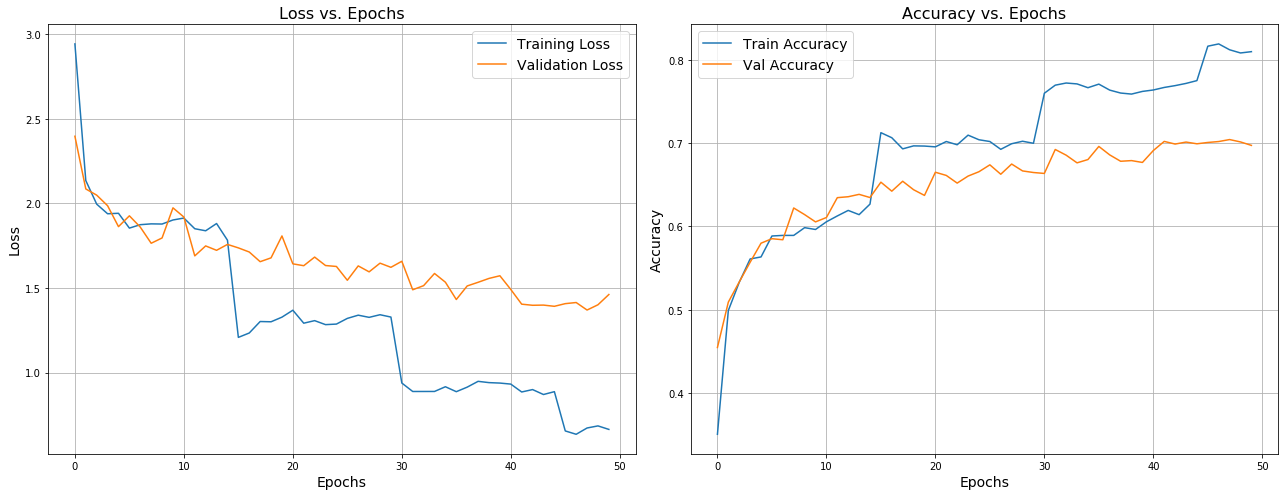

In [8]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

## Stage 2 - Data Augmentation

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
# training set
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_gen.flow_from_directory(
    train_dir, 
    batch_size=128, 
    classes=classes, 
    target_size=img_size[:2])

# validation set
val_gen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_gen.flow_from_directory(
    val_dir, 
    batch_size=286, 
    classes=classes, 
    target_size=img_size[:2])

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


In [6]:
# Load trained model
vgg16 = load_model('./models/vgg16-1-layer-dropout-stage-1-model.h5')
vgg16.layers[0].trainable = False

# Model summary
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               3211392   
Total params: 17,926,080
Trainable params: 3,211,392
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Compile the model
def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 3e-4
    if epoch > 40:
        lr *= 3e-1
    elif epoch > 30:
        lr *= 5e-1
    elif epoch > 20:
        lr *= 7e-1
    elif epoch > 10:
        lr *= 9e-1
    print('Learning rate: ', lr)
    return lr

opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16-1-layer-dropout-stage-2-ckpt.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg16.fit_generator(train_generator, steps_per_epoch=100, epochs=50, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)

vgg16.save('./models/vgg16-1-layer-dropout-stage-2-model.h5')
_ = gc.collect()

Learning rate:  0.0003
Epoch 1/50
Learning rate:  0.0003
 - 313s - loss: 2.0520 - acc: 0.5592 - val_loss: 1.4568 - val_acc: 0.6982
Epoch 2/50
Learning rate:  0.0003
 - 289s - loss: 2.0222 - acc: 0.5660 - val_loss: 1.4489 - val_acc: 0.7028
Epoch 3/50
Learning rate:  0.0003
 - 281s - loss: 1.9619 - acc: 0.5752 - val_loss: 1.4914 - val_acc: 0.6998
Epoch 4/50
Learning rate:  0.0003
 - 282s - loss: 1.9999 - acc: 0.5716 - val_loss: 1.4943 - val_acc: 0.6969
Epoch 5/50
Learning rate:  0.0003
 - 283s - loss: 1.9551 - acc: 0.5742 - val_loss: 1.4788 - val_acc: 0.7041
Epoch 6/50
Learning rate:  0.0003
 - 282s - loss: 1.9602 - acc: 0.5786 - val_loss: 1.4749 - val_acc: 0.6956
Epoch 7/50
Learning rate:  0.0003
 - 282s - loss: 1.9389 - acc: 0.5821 - val_loss: 1.4411 - val_acc: 0.7031
Epoch 8/50
Learning rate:  0.0003
 - 280s - loss: 1.8875 - acc: 0.5912 - val_loss: 1.4451 - val_acc: 0.7023
Epoch 9/50
Learning rate:  0.0003
 - 281s - loss: 1.8623 - acc: 0.5921 - val_loss: 1.4551 - val_acc: 0.6996
Epoch

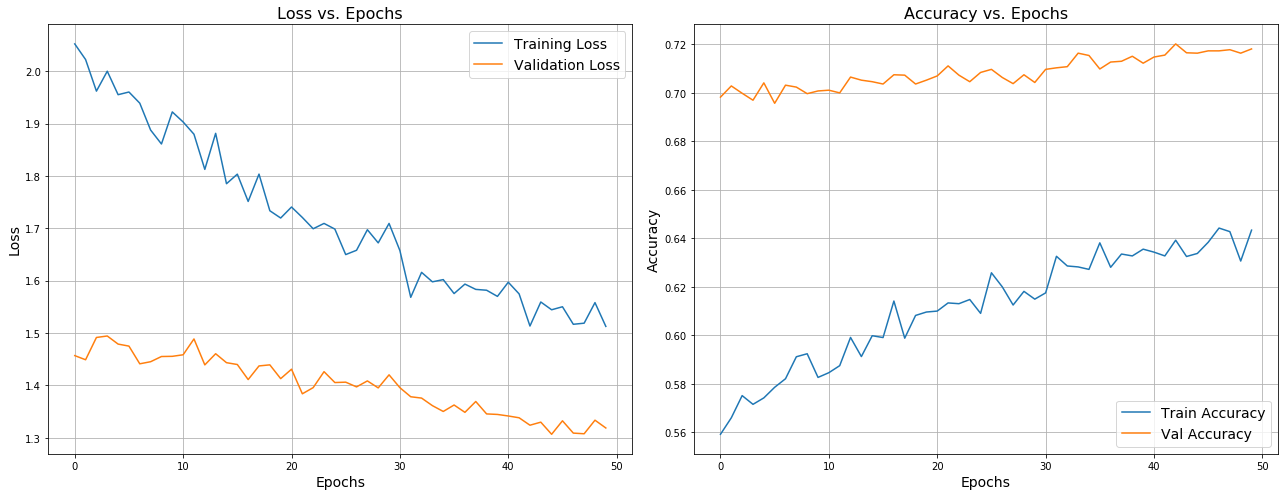

In [8]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

### Make Predictions

In [9]:
# Load test images
test_ids = []
test_images = []
for idx in test_df['id'].values:
    if os.path.exists('./data/test/' + str(idx) + '.jpg'):
        img = Image.open('./data/test/' + str(idx) + '.jpg')
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize((224, 224))
        img = np.asarray(img, dtype=K.floatx())
        test_images.append(img)
        test_ids.append(idx)

# Re-scale the images
test_images = np.array(test_images, dtype=K.floatx())
test_images = test_images / 255.0

In [12]:
# Load the saved model
vgg16 = load_model('./models/vgg16-1-layer-dropout-stage-2-ckpt.h5')

# Make predictions
test_pred = vgg16.predict(test_images)
test_label = np.argmax(test_pred, axis=1) + 1

In [13]:
# Sample submission
sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# Merge together
df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# Fill missing values
n = df_submission['predicted'].isnull().sum()
guess = np.random.choice(range(1, 129), n, replace=True)
df_submission.loc[df_submission['predicted'].isnull(), 'predicted'] = guess
df_submission['predicted'] = df_submission['predicted'].astype(int)

# Save to disk
df_submission.to_csv('./result/vgg16-1-layer-dropout-stage-2.csv', columns=['id', 'predicted'], index=False)

_ = gc.collect()